# Statistical Downscaling of CanRCM4 Model Using 2.5 km HRDPS Data
## Data Preprocessing

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import pyproj
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from pathlib import Path

In [2]:
#load in data
#first world data from 2016-2020
U_world= xr.open_dataset("uas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")
V_world = xr.open_dataset("vas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")

#next HRDPS data for all of 2018
path = Path("/home/rbeutel/analysis/eosc510/proj.ipynb").resolve().parents[2]
path2 = "/results/forcing/atmospheric/GEM2.5/operational/"

filename = []
for i in range(12):
    if i+1 in [1,3,5,8,10,12]:
        for j in range(31):
            if j+1 < 10:
                if i+1 < 10:
                    filename.append('ops_y2016m0' + str(i+1) + 'd0' + str(j+1)+'.nc')
                if i+1 >=10:
                    filename.append('ops_y2016m' + str(i+1) + 'd0' + str(j+1)+'.nc')
            if j+1 >=10:
                if i+1 < 10:
                    filename.append('ops_y2016m0' + str(i+1) + 'd'+ str(j+1)+'.nc')
                if i+1 >=10:
                    filename.append('ops_y2016m' + str(i+1) + 'd'+ str(j+1)+'.nc')
    elif i+1 == 2:
        for j in range(29): #it was a leap year in 2016
            if j+1 < 10:
                if i+1 < 10:
                    filename.append('ops_y2016m0' + str(i+1) + 'd0' +str(j+1)+'.nc')
                if i+1 >=10:
                    filename.append('ops_y2016m' + str(i+1) + 'd0'+ str(j+1)+'.nc')
            if j+1 >=10:
                if i+1 < 10:
                    filename.append('ops_y2016m0' + str(i+1) + 'd' +str(j+1)+'.nc')
                if i+1 >=10:
                    filename.append('ops_y2016m' + str(i+1) + 'd'+ str(j+1)+'.nc')
    else:
        for j in range(30):
            if j+1 < 10:
                if i+1 < 10:
                    filename.append('ops_y2016m0' + str(i+1) + 'd0' +str(j+1)+'.nc')
                if i+1 >=10:
                    filename.append('ops_y2016m' + str(i+1) + 'd0'+ str(j+1)+'.nc')
            if j+1 >=10:
                if i+1 < 10:
                    filename.append('ops_y2016m0' + str(i+1) + 'd' +str(j+1)+'.nc')
                if i+1 >=10:
                    filename.append('ops_y2016m' + str(i+1) + 'd'+ str(j+1)+'.nc')

files = [path/path2/filename[i] for i in range(len(filename))]
hrdps = xr.open_mfdataset(files)

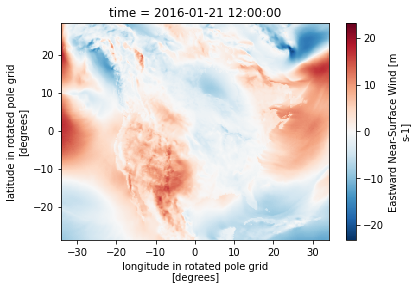

In [3]:
U_world.uas[20,:,:].plot()
#plt.savefig('RCMdata.png')

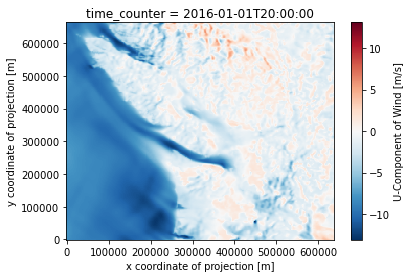

In [4]:
hrdps.u_wind[20,:,:].plot()
#plt.savefig('HRDPSdata.png')

In [5]:
#next we want the HRDPS data to be daily instead of hourly
hrdps = hrdps.resample(time_counter='D').mean(dim='time_counter')

#and then trim the components you want to work with to be in a more relevant extent 
#(dont need the HRDPS data to stretch as far as it does inland)
#NOTE: 
u_temp = hrdps.u_wind.sel(x=slice(0., 480000.)).values
v_temp = hrdps.v_wind.sel(x=slice(0., 480000.)).values
hrdps_lat = hrdps.nav_lat.sel(x=slice(0., 480000.)).values
hrdps_lon = hrdps.nav_lon.sel(x=slice(0., 480000.)).values

In [6]:
#now extract the lat, lon, U, and V and get into form that I can work with
hrdps_lat = hrdps_lat[0,:,:].flatten()
hrdps_lon = hrdps_lon[0,:,:].flatten()

In [7]:
#U and V to 2D - space is the m component in my research question not time
U_hrdps = np.empty((np.shape(u_temp)[1]*np.shape(u_temp)[2],np.shape(u_temp)[0]))
for i in range(np.shape(u_temp)[0]):
    U_hrdps[:,i] = np.reshape(u_temp[i],(np.shape(u_temp)[1]*np.shape(u_temp)[2],))

V_hrdps = np.empty((np.shape(v_temp)[1]*np.shape(v_temp)[2],np.shape(v_temp)[0]))
for i in range(np.shape(v_temp)[0]):
    V_hrdps[:,i] = np.reshape(v_temp[i],(np.shape(v_temp)[1]*np.shape(v_temp)[2],))

In [8]:
#trim the world dataset to be for right time extent
#want days between June 1 2018 and June 30 2018
U_world = U_world.sel(time=slice('2018-01-01 12:00:00', '2018-12-31 12:00:00')) 
V_world = V_world.sel(time=slice('2018-01-01 12:00:00', '2018-12-31 12:00:00')) 

In [ ]:
#now extract the data you want from the CanRCM4 xarray and trim them according to lat and lon of the HRDPS data
#first decide on range you want to work within for CanRCM4 data, want to overlap the HRDPS data by 10 the max distance (y)
buffer = (max(hrdps_lat)-min(hrdps_lat))*0.1

lon = U_world.lon.values.flatten()#-360 #substracting 360 to get these in correct was an assumption based on the values of the array
lat = U_world.lat.values.flatten()
index = []

#first find idexes that fit into lon range and lat range
for i in range(len(lon)):
    if lon[i] > (min(hrdps_lon)-buffer) and lon[i] < (max(hrdps_lon)+buffer) and lat[i] > (min(hrdps_lat)-buffer) and lat[i] < (max(hrdps_lat)+buffer):
        index.append(i)

#now make new lat, and lon
lat_RCM = []
lon_RCM = []

for i in index:
    lat_RCM.append(lat[i])
    lon_RCM.append(lon[i])

In [ ]:
#now convert the wind data to 2D and use the idices found in the previous step to trim it
U2d = np.empty((np.shape(U_world.uas.values)[1]*np.shape(U_world.uas.values)[2],np.shape(U_world.uas.values)[0]))
for i in range(np.shape(U_world.uas.values)[0]):
    U2d[:,i] = np.reshape(U_world.uas.values[i],(np.shape(U_world.uas.values)[1]*np.shape(U_world.uas.values)[2],))

V2d = np.empty((np.shape(V_world.vas.values)[1]*np.shape(V_world.vas.values)[2],np.shape(V_world.vas.values)[0]))
for i in range(np.shape(V_world.vas.values)[0]):
    V2d[:,i] = np.reshape(V_world.vas.values[i],(np.shape(V_world.vas.values)[1]*np.shape(V_world.vas.values)[2],))

U_RCM = np.empty((len(index),np.shape(U_hrdps)[1]))
V_RCM = np.empty((len(index),np.shape(V_hrdps)[1]))

for i in range(np.shape(V_hrdps)[1]):
    for j in range(len(index)):
        U_RCM[j,i] = U2d[index[j],i]
        V_RCM[j,i] = V2d[index[j],i]

In [ ]:
#visualize preprocessing
plt.figure(figsize=(8,5))

plt.scatter(lon_RCM, lat_RCM,
            c = U_RCM[:,0],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

## PCA 
First on CanRCM4 Model

In [12]:
#PCA on the world data
#looking for dominant spatial patterns to be eigenvectors and how those spatial patterns evelove over the month to the the PCs)
#need to take the transpose of the matrix 

data = U_RCM.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
U_RCM_PCs = pca.fit_transform(data)
U_RCM_eigvecs = pca.components_
U_RMCfracVar = pca.explained_variance_ratio_

data = V_RCM.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
V_RCM_PCs = pca.fit_transform(data)
V_RCM_eigvecs = pca.components_
V_RMCfracVar = pca.explained_variance_ratio_

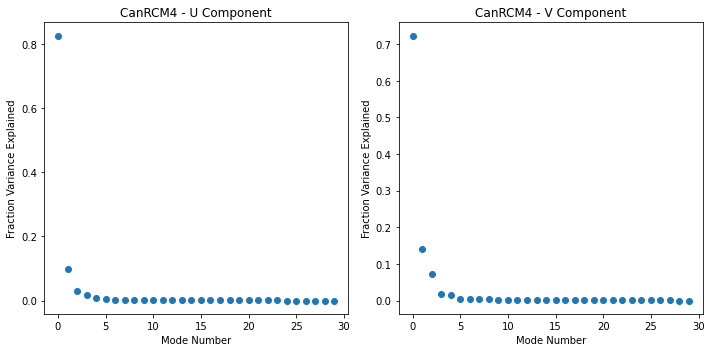

In [13]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(U_RMCfracVar)),U_RMCfracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('CanRCM4 - U Component')

plt.subplot(1,2,2)
plt.scatter(range(len(V_RMCfracVar)),V_RMCfracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('CanRCM4 - V Component')

plt.tight_layout()

plt.show()

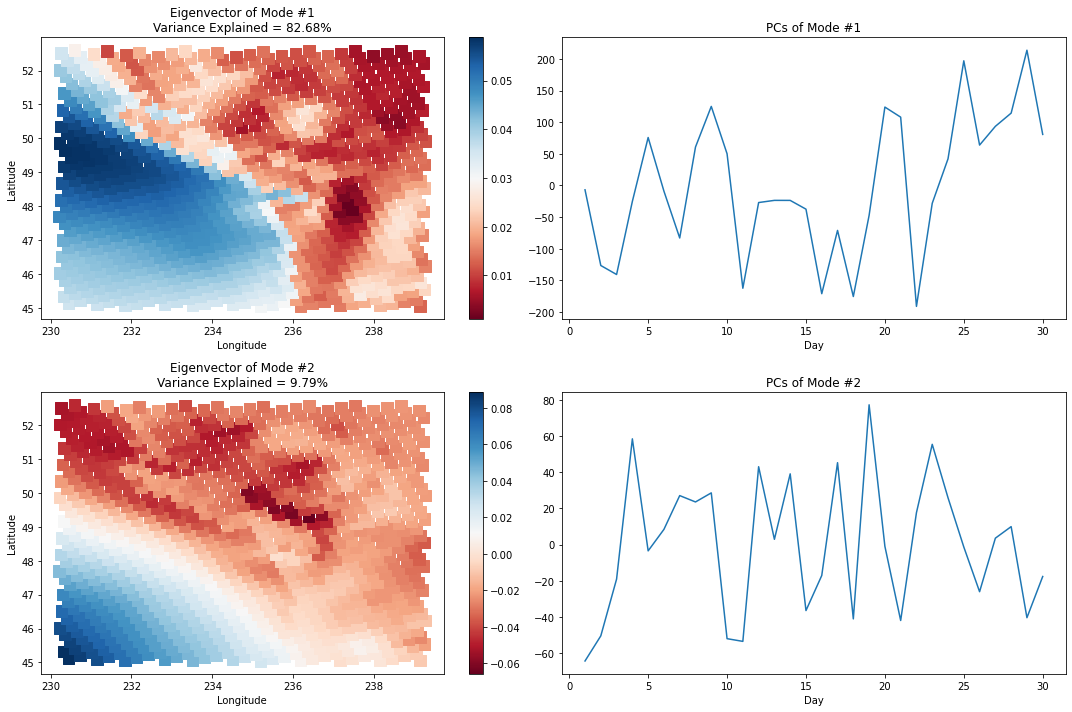

In [14]:
#keep first two modes for U
#visualise U component
n = 2
day1 = 1
dayfinal = 30

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(lon_RCM, lat_RCM,
            c = U_RCM_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(U_RMCfracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),U_RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()
    
plt.savefig('PCA-RXM-U.png')

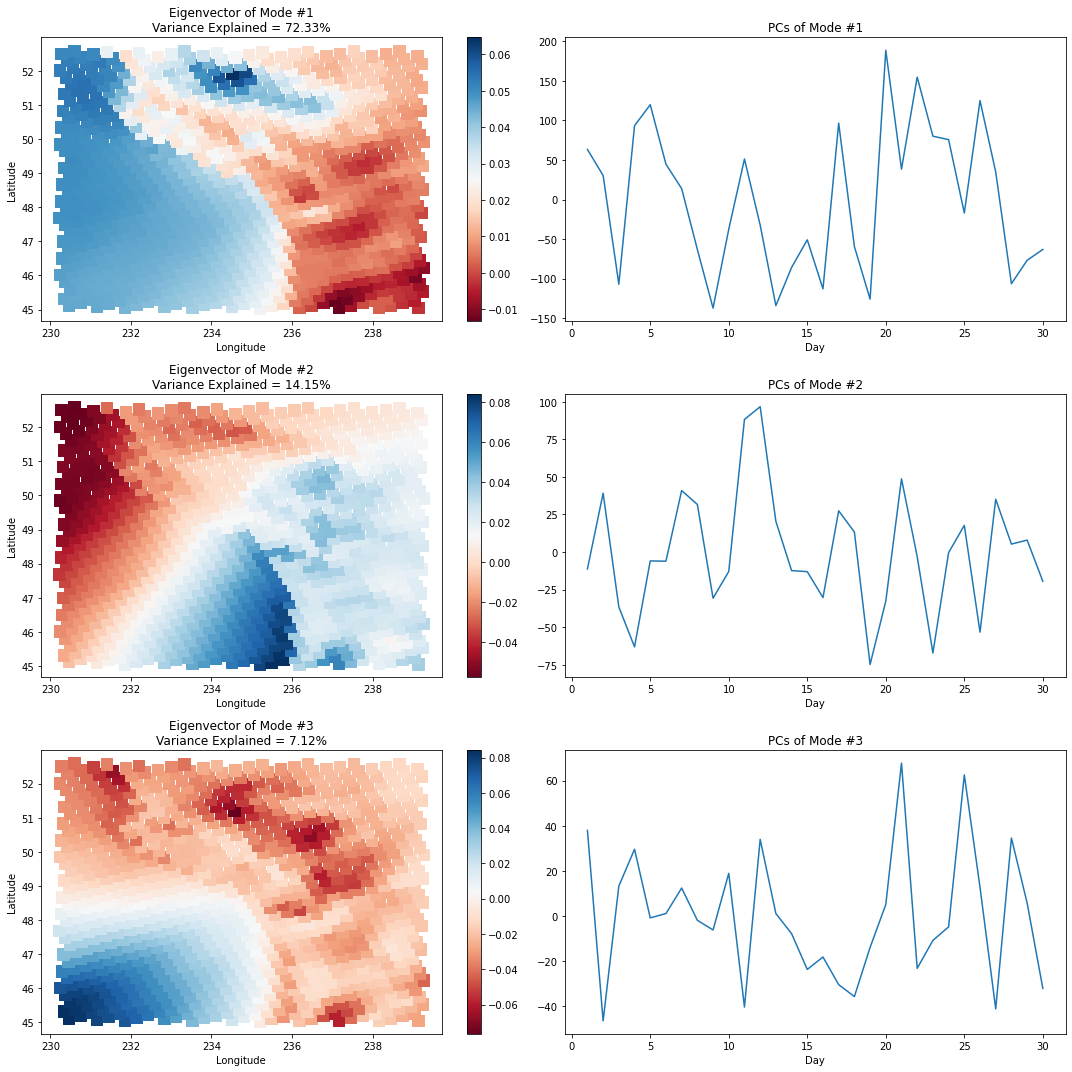

In [15]:
#keep first three modes for V
#visualize V component
n = 3

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(lon_RCM, lat_RCM,
            c = V_RCM_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 133,
            marker ='s')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(V_RMCfracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),V_RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

plt.savefig('PCA-RXM-V.png')

Now on the HRDPS Data

In [33]:
#PCA on the HRDPS data 

data = (pd.DataFrame(U_hrdps.T).fillna(0)).to_numpy() 
#there are nan's in the data which ou can't do PCA on, for now relace with 0 - ask Susan if this is the right choice

n_modes = np.min(np.shape(data))
Upca = PCA(n_components = n_modes)
U_hrdps_PCs = Upca.fit_transform(data)
U_hrdps_eigvecs = Upca.components_
U_hrdps_fracVar = Upca.explained_variance_ratio_

data = (pd.DataFrame(V_hrdps.T).fillna(0)).to_numpy()

n_modes = np.min(np.shape(data))
Vpca = PCA(n_components = n_modes)
V_hrdps_PCs = Vpca.fit_transform(data)
V_hrdps_eigvecs = Vpca.components_
V_hrdps_fracVar = Vpca.explained_variance_ratio_

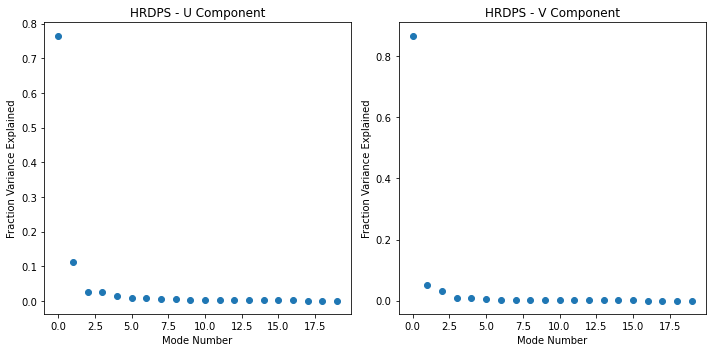

In [38]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(U_hrdps_fracVar[0:20])),U_hrdps_fracVar[0:20]) #plot only first 20
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - U Component')

plt.subplot(1,2,2)
plt.scatter(range(len(V_hrdps_fracVar[0:20])),V_hrdps_fracVar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('HRDPS - V Component')

plt.tight_layout()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (30,) and (366,)

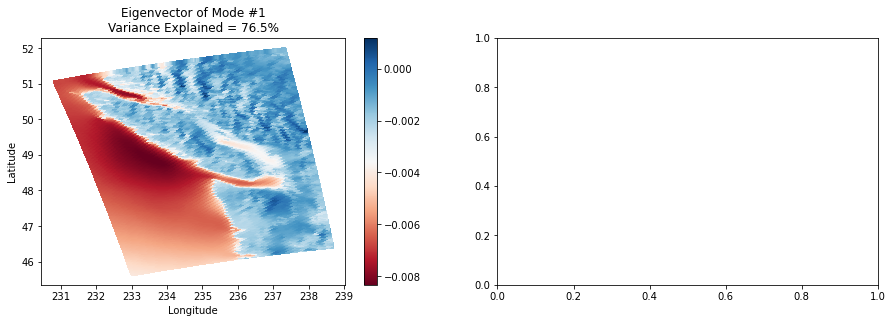

In [39]:
#keep first two modes for U component
#visualise U component
n = 2

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = U_hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(U_hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),U_hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

plt.savefig('PCA-HRDPS-U.png')

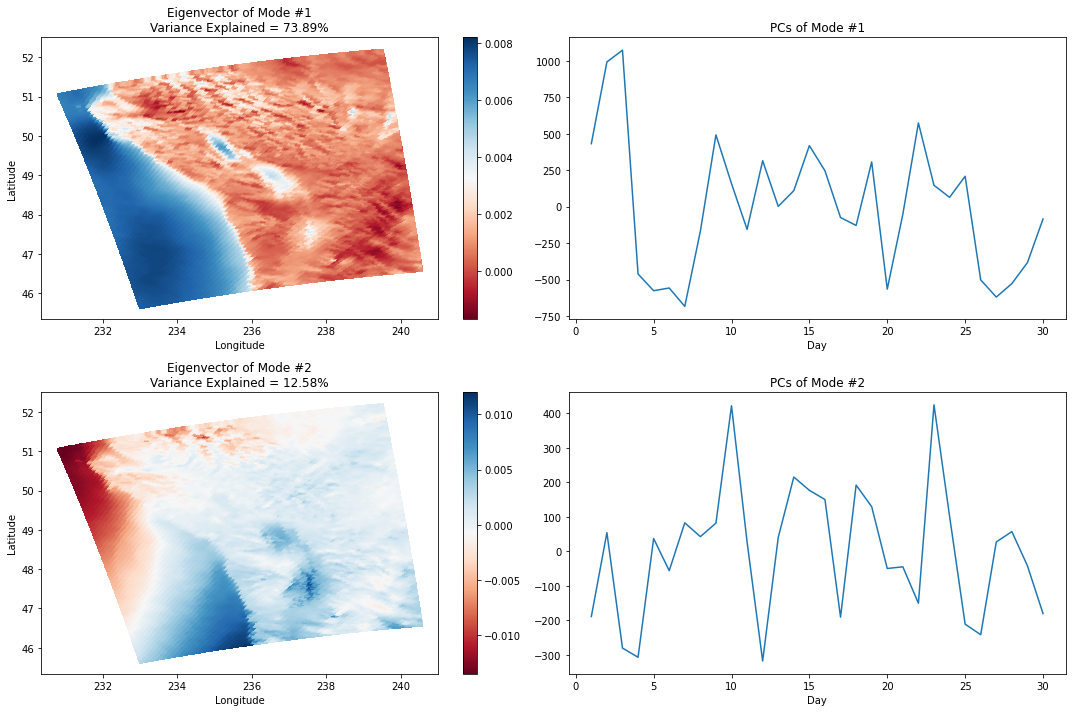

In [17]:
#keep first two modes for V component
#visualise V component
n =2

plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = V_hrdps_eigvecs[kk,:],
            cmap = 'RdBu',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(V_hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),V_hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

plt.savefig('PCA-HRDPS-V.png')

## Grid-search optimization
First with U-component

In [18]:
#define RMSE as a function
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [19]:
#set training and validation data
#recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
nPCs = 3

x = U_RCM_PCs[:,:nPCs] #CanRCM4 PCAs as input
y = U_hrdps_PCs[:,:nPCs] #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

In [20]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: play around with it!

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 30 #maximum number of hidden neurons to loop through, times steps for training equals 30 at this moment
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 20
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.001
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.25 #fraction of training data to use as validation
#####

y_out_all_nhn = []
# q5y_all = []
# q5y_ensemble = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 BEST: 2 hidden layers, 10 hidden neurons
Model Number: 1
	 BEST: 2 hidden layers, 13 hidden neurons
Model Number: 2
	 BEST: 2 hidden layers, 12 hidden neurons
Model Number: 3
	 BEST: 2 hidden layers, 24 hidden neurons
Model Number: 4
	 BEST: 1 hidden layers, 9 hidden neurons
Model Number: 5
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 6
	 BEST: 2 hidden layers, 23 hidden neurons
Model Number: 7
	 BEST: 2 hidden layers, 24 hidden neurons
Model Number: 8
	 BEST: 2 hidden layers, 26 hidden neurons
Model Number: 9
	 BEST: 1 hidden layers, 16 hidden neurons
Model Number: 10
	 BEST: 2 hidden layers, 23 hidden neurons
Model Number: 11
	 BEST: 2 hidden layers, 24 hidden neurons
Model Number: 12
	 BEST: 2 hidden layers, 18 hidden neurons
Model Number: 13
	 BEST: 2 hidden layers, 28 hidden neurons
Model Number: 14
	 BEST: 2 hidden layers, 30 hidden neurons
Model Number: 15
	 BEST: 1 hidden layers, 24 hidden neurons
Model Number: 16
	 BEST: 1 hidden layers, 30 hidden 

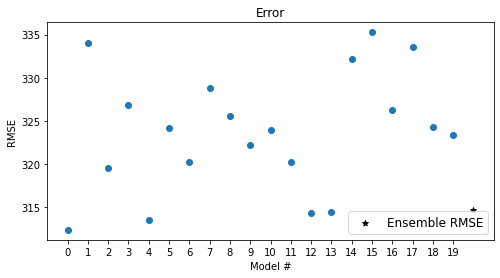

In [21]:
#plot RMSE for each run
plt.figure(figsize=(8,4))

plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*',label='Ensemble RMSE')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.xticks(np.arange(0, 20, step=1))
plt.ylabel('RMSE')
plt.title('Error')
plt.legend(fontsize = 12, loc = 'best')

plt.savefig('RMSE.png')

In [22]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
U_model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(U_model)

MLPRegressor(batch_size=20, early_stopping=True, hidden_layer_sizes=(10, 2),
             max_iter=2000, solver='sgd', validation_fraction=0.25)


Next with V component

In [24]:
#set training and validation data
#recall that we chose 3 PCs for RCM model u-component and 2 PCs for HRDPS u-component
nPCs = 2


x = V_RCM_PCs[:,:nPCs] #CanRCM4 PCAs as input
y = V_hrdps_PCs[:,:nPCs] #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

In [25]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: play around with it!

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 30 #maximum number of hidden neurons to loop through, times steps for training equals 30 at this moment
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 20
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.001
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.25 #fraction of training data to use as validation
#####

y_out_all_nhn = []
# q5y_all = []
# q5y_ensemble = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 BEST: 2 hidden layers, 14 hidden neurons
Model Number: 1
	 BEST: 2 hidden layers, 12 hidden neurons
Model Number: 2
	 BEST: 1 hidden layers, 21 hidden neurons
Model Number: 3
	 BEST: 2 hidden layers, 11 hidden neurons
Model Number: 4
	 BEST: 2 hidden layers, 12 hidden neurons
Model Number: 5
	 BEST: 1 hidden layers, 18 hidden neurons
Model Number: 6
	 BEST: 1 hidden layers, 15 hidden neurons
Model Number: 7
	 BEST: 1 hidden layers, 10 hidden neurons
Model Number: 8
	 BEST: 2 hidden layers, 17 hidden neurons
Model Number: 9
	 BEST: 2 hidden layers, 10 hidden neurons
Model Number: 10
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 11
	 BEST: 2 hidden layers, 14 hidden neurons
Model Number: 12
	 BEST: 2 hidden layers, 22 hidden neurons
Model Number: 13
	 BEST: 2 hidden layers, 6 hidden neurons
Model Number: 14
	 BEST: 2 hidden layers, 11 hidden neurons
Model Number: 15
	 BEST: 2 hidden layers, 12 hidden neurons
Model Number: 16
	 BEST: 2 hidden layers, 7 hidden n

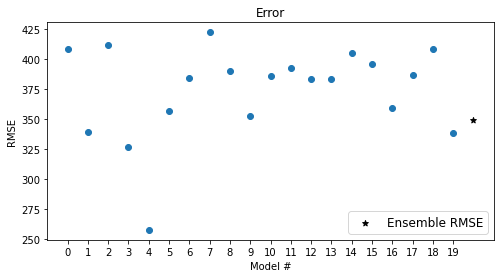

In [26]:
#plot RMSE for each run
plt.figure(figsize=(8,4))

plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*',label='Ensemble RMSE')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.xticks(np.arange(0, 20, step=1))
plt.ylabel('RMSE')
plt.title('Error')
plt.legend(fontsize = 12, loc = 'best')

plt.savefig('RMSE2.png')

In [27]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
V_model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(V_model)

MLPRegressor(batch_size=20, early_stopping=True, hidden_layer_sizes=(12, 2),
             max_iter=2000, solver='sgd', validation_fraction=0.25)


## Future prediction and reconstruction

In [28]:
#lets load in one more month of CanRCM4 model and make a 'prediction' on what the winds would look like in that month
Ufuture= xr.open_dataset("uas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")
Vfuture = xr.open_dataset("vas_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")

#want days between July 1 2018 and July 31 2018
Ufuture = Ufuture.sel(time=slice('2018-06-01 12:00:00', '2018-06-30 12:00:00')) 
Vfuture = Vfuture.sel(time=slice('2018-06-01 12:00:00', '2018-06-30 12:00:00'))

#now extract the data you want from the CanRCM4 xarray and trim them according to lat and lon of the HRDPS data
#don't need to retrim or re-extract the lat and lon coordinates as they will be the same as before
#convert the wind data to 2D and use the idices found earlier to trim it
U2d = np.empty((np.shape(Ufuture.uas.values)[1]*np.shape(Ufuture.uas.values)[2],np.shape(Ufuture.uas.values)[0]))
for i in range(np.shape(Ufuture.uas.values)[0]):
    U2d[:,i] = np.reshape(Ufuture.uas.values[i],(np.shape(Ufuture.uas.values)[1]*np.shape(Ufuture.uas.values)[2],))

V2d = np.empty((np.shape(Vfuture.vas.values)[1]*np.shape(Vfuture.vas.values)[2],np.shape(Vfuture.vas.values)[0]))
for i in range(np.shape(Vfuture.vas.values)[0]):
    V2d[:,i] = np.reshape(Vfuture.vas.values[i],(np.shape(Vfuture.vas.values)[1]*np.shape(Vfuture.vas.values)[2],))

Ufuture = np.empty((len(index),30))
Vfuture = np.empty((len(index),30))

for i in range(30):
    for j in range(len(index)):
        Ufuture[j,i] = U2d[index[j],i]
        Vfuture[j,i] = V2d[index[j],i]

In [29]:
#do PCA and take the same amount of modes as before (only actually need the PCs not the eigenvecs)
data = Ufuture.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
U_PCs = pca.fit_transform(data)

data = Vfuture.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
V_PCs = pca.fit_transform(data)

In [30]:
#put input data in correct form
U = U_PCs[:,:3] 
V = V_PCs[:,:2] 

In [31]:
#predict
U_PCoutput = U_model.predict(U)
V_PCoutput = V_model.predict(V)

In [32]:
#reconstruct this bitch

numObs = np.shape(U_hrdps_eigvecs)[0]
data_U_rec = np.empty([numObs,68096])
for kk in range(numObs): #for each time step
    this_U_rec = np.zeros([1,68096])
    for mode in range(3): #range is number of modes we kept (3 for U and 2 for V)
        this_U_rec += U_hrdps_eigvecs[mode,:]*U_PCoutput[kk,mode]    
    data_U_rec[kk,:] = this_U_rec
    
numObs = np.shape(V_hrdps_eigvecs)[0]
data_V_rec = np.empty([numObs,68096])
for kk in range(numObs): #for each time step
    this_V_rec = np.zeros([1,68096])
    for mode in range(2): #range is number of modes we kept (3 for U and 2 for V)
        this_V_rec += U_hrdps_eigvecs[mode,:]*V_PCoutput[kk,mode]    
    data_V_rec[kk,:] = this_V_rec


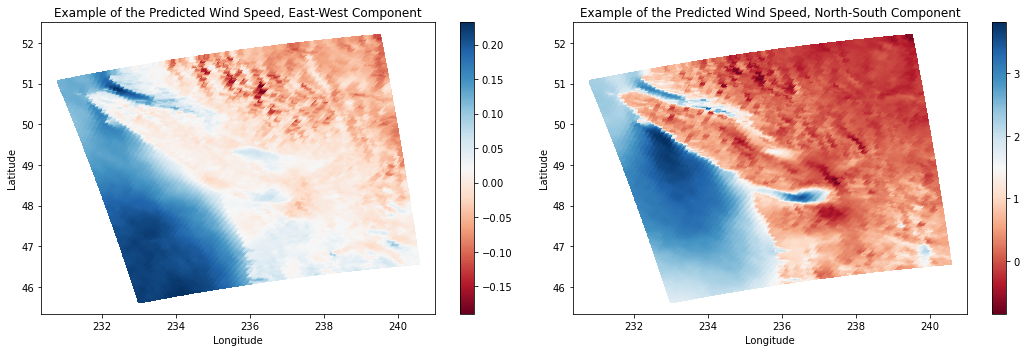

In [33]:
#visualize reconstruction
plt.figure(figsize=(15,5))

    
plt.subplot(1,2,1)
plt.scatter(hrdps_lon, hrdps_lat,
            c = data_U_rec[0,:],
            cmap = 'RdBu',
            s = 10,
            marker = 's')
plt.title('Example of the Predicted Wind Speed, East-West Component')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(hrdps_lon, hrdps_lat,
            c = data_V_rec[0,:],
            cmap = 'RdBu',
            s = 10,
            marker = 's')
plt.title('Example of the Predicted Wind Speed, North-South Component')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.savefig('Reconstruction.png')

plt.tight_layout()

In [34]:
#load in actual HRDPS data from that day to compare
compare= xr.open_dataset("operational/ops_y2016m06d01.nc")

#get into daily
compare = compare.resample(time_counter='D').mean(dim='time_counter')


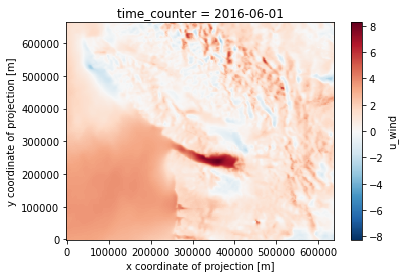

In [35]:
#plot u component
compare.u_wind[0,:,:].plot()
#plt.savefig('HRDPSdata.png')

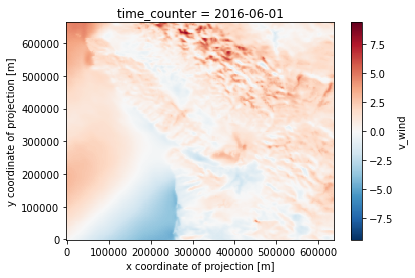

In [36]:
#plot v component
compare.v_wind[0,:,:].plot()